# TimeGAN training notebook

- Paper: Jinsung Yoon, Daniel Jarrett, Mihaela van der Schaar, "Time-series Generative Adversarial Networks," Neural Information Processing Systems (NeurIPS), 2019.

- Paper link: https://papers.nips.cc/paper/8789-time-series-generative-adversarial-networks

## Necessary packages and functions 

In [3]:
## Install timegan requirments
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import os


os.chdir('../functions/timegan')
!pip install seaborn_qqplot
!pip install pyarrow
!pip install sklearn
!pip install -r requirements.txt 



from datetime import datetime
from datetime import timedelta
from os import path


import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='whitegrid', rc = {'figure.figsize':(20,8)})

import numpy as np
import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
# 1. TimeGAN model
# from timegan import timegan
import pandas as pd
# # 2. Data loading
# from data_loading import real_data_loading, sine_data_generation
# 3. Metrics
# from metrics.discriminative_metrics import discriminative_score_metrics
# from metrics.predictive_metrics import predictive_score_metrics
# from metrics.visualization_metrics import visualization
import time
import tensorflow as tf
from utils import extract_time, rnn_cell, random_generator, batch_generator

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
  Using cached argparse-1.4.0-py2.py3-none-any.whl (23 kB)


In [4]:
# import the preprocessing functions 
os.chdir('..')
%matplotlib inline
import s3fs
s3fs.__version__
from cluster_data import *
from utility import *

# Altered codebase from paper

In [17]:

"""Time-series Generative Adversarial Networks (TimeGAN) Codebase.

Reference: Jinsung Yoon, Daniel Jarrett, Mihaela van der Schaar, 
"Time-series Generative Adversarial Networks," 
Neural Information Processing Systems (NeurIPS), 2019.

Paper link: https://papers.nips.cc/paper/8789-time-series-generative-adversarial-networks

Last updated Date: April 24th 2020
Code author: Jinsung Yoon (jsyoon0823@gmail.com)

-----------------------------

timegan.py

Note: Use original data as training set to generater synthetic data (time-series)
"""


def timegan (ori_data, parameters, pretrained_path=None):
  """TimeGAN function.
  
  Use original data as training set to generater synthetic data (time-series)
  
  Args:
    - ori_data: original time-series data
    - parameters: TimeGAN network parameters
    
  Returns:
    - generated_data: generated time-series data
  """
  # Initialization on the Graph
  tf.reset_default_graph()

  # Basic Parameters
  no, seq_len, dim = np.asarray(ori_data).shape
    
  # Maximum sequence length and each sequence length
  ori_time, max_seq_len = extract_time(ori_data)
  
  def MinMaxScaler(data):
    """Min-Max Normalizer.
    
    Args:
      - data: raw data
      
    Returns:
      - norm_data: normalized data
      - min_val: minimum values (for renormalization)
      - max_val: maximum values (for renormalization)
    """    
    min_val = np.min(np.min(data, axis = 0), axis = 0)
    data = data - min_val
      
    max_val = np.max(np.max(data, axis = 0), axis = 0)
    norm_data = data / (max_val + 1e-7)
      
    return norm_data, min_val, max_val
  
  # Normalization
  ori_data, min_val, max_val = MinMaxScaler(ori_data)
              
  ## Build a RNN networks          
  
  # Network Parameters
  hidden_dim   = parameters['hidden_dim'] 
  num_layers   = parameters['num_layer']
  iterations   = parameters['iterations']
  batch_size   = parameters['batch_size']
  module_name  = parameters['module'] 
  z_dim        = dim
  gamma        = 1
    
  # Input place holders
  X = tf.placeholder(tf.float32, [None, max_seq_len, dim], name = "myinput_x")
  Z = tf.placeholder(tf.float32, [None, max_seq_len, z_dim], name = "myinput_z")
  T = tf.placeholder(tf.int32, [None], name = "myinput_t")
  
  def embedder (X, T):
    """Embedding network between original feature space to latent space.
    
    Args:
      - X: input time-series features
      - T: input time information
      
    Returns:
      - H: embeddings
    """
    with tf.variable_scope("embedder", reuse = tf.AUTO_REUSE):
      e_cell = tf.nn.rnn_cell.MultiRNNCell([rnn_cell(module_name, hidden_dim) for _ in range(num_layers)])
      e_outputs, e_last_states = tf.nn.dynamic_rnn(e_cell, X, dtype=tf.float32, sequence_length = T)
      H = tf.contrib.layers.fully_connected(e_outputs, hidden_dim, activation_fn=tf.nn.sigmoid)     
    return H
      
  def recovery (H, T):   
    """Recovery network from latent space to original space.
    
    Args:
      - H: latent representation
      - T: input time information
      
    Returns:
      - X_tilde: recovered data
    """     
    with tf.variable_scope("recovery", reuse = tf.AUTO_REUSE):       
      r_cell = tf.nn.rnn_cell.MultiRNNCell([rnn_cell(module_name, hidden_dim) for _ in range(num_layers)])
      r_outputs, r_last_states = tf.nn.dynamic_rnn(r_cell, H, dtype=tf.float32, sequence_length = T)
      X_tilde = tf.contrib.layers.fully_connected(r_outputs, dim, activation_fn=tf.nn.sigmoid) 
      
    return X_tilde
    
  def generator (Z, T):  
    """Generator function: Generate time-series data in latent space.
    
    Args:
      - Z: random variables
      - T: input time information
      
    Returns:
      - E: generated embedding
    """        
    with tf.variable_scope("generator", reuse = tf.AUTO_REUSE):
      e_cell = tf.nn.rnn_cell.MultiRNNCell([rnn_cell(module_name, hidden_dim) for _ in range(num_layers)])
      e_outputs, e_last_states = tf.nn.dynamic_rnn(e_cell, Z, dtype=tf.float32, sequence_length = T)
      E = tf.contrib.layers.fully_connected(e_outputs, hidden_dim, activation_fn=tf.nn.sigmoid)     
    return E
      
  def supervisor (H, T): 
    """Generate next sequence using the previous sequence.
    
    Args:
      - H: latent representation
      - T: input time information
      
    Returns:
      - S: generated sequence based on the latent representations generated by the generator
    """          
    with tf.variable_scope("supervisor", reuse = tf.AUTO_REUSE):
      e_cell = tf.nn.rnn_cell.MultiRNNCell([rnn_cell(module_name, hidden_dim) for _ in range(num_layers-1)])
      e_outputs, e_last_states = tf.nn.dynamic_rnn(e_cell, H, dtype=tf.float32, sequence_length = T)
      S = tf.contrib.layers.fully_connected(e_outputs, hidden_dim, activation_fn=tf.nn.sigmoid)     
    return S
          
  def discriminator (H, T):
    """Discriminate the original and synthetic time-series data.
    
    Args:
      - H: latent representation
      - T: input time information
      
    Returns:
      - Y_hat: classification results between original and synthetic time-series
    """        
    with tf.variable_scope("discriminator", reuse = tf.AUTO_REUSE):
      d_cell = tf.nn.rnn_cell.MultiRNNCell([rnn_cell(module_name, hidden_dim) for _ in range(num_layers)])
      d_outputs, d_last_states = tf.nn.dynamic_rnn(d_cell, H, dtype=tf.float32, sequence_length = T)
      Y_hat = tf.contrib.layers.fully_connected(d_outputs, 1, activation_fn=None) 
    return Y_hat   
    
  # Embedder & Recovery
  H = embedder(X, T)
  X_tilde = recovery(H, T)
    
  # Generator
  E_hat = generator(Z, T)
  H_hat = supervisor(E_hat, T)
  H_hat_supervise = supervisor(H, T)
    
  # Synthetic data
  X_hat = recovery(H_hat, T)
    
  # Discriminator
  Y_fake = discriminator(H_hat, T)
  Y_real = discriminator(H, T)     
  Y_fake_e = discriminator(E_hat, T)
    
  # Variables        
  e_vars = [v for v in tf.trainable_variables() if v.name.startswith('embedder')]
  r_vars = [v for v in tf.trainable_variables() if v.name.startswith('recovery')]
  g_vars = [v for v in tf.trainable_variables() if v.name.startswith('generator')]
  s_vars = [v for v in tf.trainable_variables() if v.name.startswith('supervisor')]
  d_vars = [v for v in tf.trainable_variables() if v.name.startswith('discriminator')]
    
  # Discriminator loss
  D_loss_real = tf.losses.sigmoid_cross_entropy(tf.ones_like(Y_real), Y_real)
  D_loss_fake = tf.losses.sigmoid_cross_entropy(tf.zeros_like(Y_fake), Y_fake)
  D_loss_fake_e = tf.losses.sigmoid_cross_entropy(tf.zeros_like(Y_fake_e), Y_fake_e)
  D_loss = D_loss_real + D_loss_fake + gamma * D_loss_fake_e
            
  # Generator loss
  # 1. Adversarial loss
  G_loss_U = tf.losses.sigmoid_cross_entropy(tf.ones_like(Y_fake), Y_fake)
  G_loss_U_e = tf.losses.sigmoid_cross_entropy(tf.ones_like(Y_fake_e), Y_fake_e)
    
  # 2. Supervised loss
  G_loss_S = tf.losses.mean_squared_error(H[:,1:,:], H_hat_supervise[:,:-1,:])
    
  # 3. Two Momments
  G_loss_V1 = tf.reduce_mean(tf.abs(tf.sqrt(tf.nn.moments(X_hat,[0])[1] + 1e-6) - tf.sqrt(tf.nn.moments(X,[0])[1] + 1e-6)))
  G_loss_V2 = tf.reduce_mean(tf.abs((tf.nn.moments(X_hat,[0])[0]) - (tf.nn.moments(X,[0])[0])))
    
  G_loss_V = G_loss_V1 + G_loss_V2
    
  # 4. Summation
  G_loss = G_loss_U + gamma * G_loss_U_e + 100 * tf.sqrt(G_loss_S) + 100*G_loss_V 
            
  # Embedder network loss
  E_loss_T0 = tf.losses.mean_squared_error(X, X_tilde)
  E_loss0 = 10*tf.sqrt(E_loss_T0)
  E_loss = E_loss0  + 0.1*G_loss_S
    
  # optimizer
  E0_solver = tf.train.AdamOptimizer().minimize(E_loss0, var_list = e_vars + r_vars)
  E_solver = tf.train.AdamOptimizer().minimize(E_loss, var_list = e_vars + r_vars)
  D_solver = tf.train.AdamOptimizer().minimize(D_loss, var_list = d_vars)
  G_solver = tf.train.AdamOptimizer().minimize(G_loss, var_list = g_vars + s_vars)      
  GS_solver = tf.train.AdamOptimizer().minimize(G_loss_S, var_list = g_vars + s_vars)   

  ####################################################################################################### 
  ## Load a pre-trained TimeGAN model
  ####################################################################################################### 
  if pretrained_path != None: # use a saved model
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())    
    
    #load meta graph and restore weights
    saver = tf.train.import_meta_graph(f'{model_dir}{model_name}.meta')
    saver.restore(sess, tf.train.latest_checkpoint(f'{model_dir}'))
 
    #Now, access the op that you want to run. 
    graph = tf.get_default_graph()
    X_input =  graph.get_tensor_by_name('myinput_x:0')
    Z_input =  graph.get_tensor_by_name('myinput_z:0')
    T_input =  graph.get_tensor_by_name('myinput_t:0')
    op_to_restore = graph.get_tensor_by_name("recovery_1/fully_connected/Sigmoid:0")

    # Now, let's access and create placeholders variables and
    # create feed-dict to feed new data

#     start_time = time.time()
    Z_mb = random_generator(no, z_dim, ori_time, max_seq_len)
    generated_data_curr = sess.run(op_to_restore, feed_dict={Z_input: Z_mb, X_input: ori_data, T_input: ori_time})
      
    generated_data = list()
    
    
      
    for i in range(no):
      temp = generated_data_curr[i,:ori_time[i],:]
      generated_data.append(temp)
          
    # Renormalization
    generated_data = generated_data * max_val
    generated_data = generated_data + min_val
      
#     print("--- %s seconds ---" % (time.time() - start_time))

    return ori_time, generated_data
    #This will print 60 which is calculated 
    #using new values of w1 and w2 and saved value of b1. 

        
  ####################################################################################################### 
  ## TimeGAN training   
  ####################################################################################################### 
  sess = tf.Session()
  sess.run(tf.global_variables_initializer())
    
  # 1. Embedding network training
  print('Start Embedding Network Training')
    
  for itt in range(iterations):
    # Set mini-batch
    X_mb, T_mb = batch_generator(ori_data, ori_time, batch_size)           
    # Train embedder        
    _, step_e_loss = sess.run([E0_solver, E_loss_T0], feed_dict={X: X_mb, T: T_mb})        
    # Checkpoint
    if itt % 1000 == 0:
      print('step: '+ str(itt) + '/' + str(iterations) + ', e_loss: ' + str(np.round(np.sqrt(step_e_loss),4)) ) 
      
  print('Finish Embedding Network Training')
    
  # 2. Training only with supervised loss
  print('Start Training with Supervised Loss Only')
    
  for itt in range(iterations):
    # Set mini-batch
    X_mb, T_mb = batch_generator(ori_data, ori_time, batch_size)    
    # Random vector generation   
    Z_mb = random_generator(batch_size, z_dim, T_mb, max_seq_len)
    # Train generator       
    _, step_g_loss_s = sess.run([GS_solver, G_loss_S], feed_dict={Z: Z_mb, X: X_mb, T: T_mb})       
    # Checkpoint
    if itt % 1000 == 0:
      print('step: '+ str(itt)  + '/' + str(iterations) +', s_loss: ' + str(np.round(np.sqrt(step_g_loss_s),4)) )
      
  print('Finish Training with Supervised Loss Only')
    
  # 3. Joint Training
  print('Start Joint Training')
  
  for itt in range(iterations):
    # Generator training (twice more than discriminator training)
    for kk in range(2):
      # Set mini-batch
      X_mb, T_mb = batch_generator(ori_data, ori_time, batch_size)               
      # Random vector generation
      Z_mb = random_generator(batch_size, z_dim, T_mb, max_seq_len)
      # Train generator
      _, step_g_loss_u, step_g_loss_s, step_g_loss_v = sess.run([G_solver, G_loss_U, G_loss_S, G_loss_V], feed_dict={Z: Z_mb, X: X_mb, T: T_mb})
       # Train embedder        
      _, step_e_loss_t0 = sess.run([E_solver, E_loss_T0], feed_dict={Z: Z_mb, X: X_mb, T: T_mb})   
           
    # Discriminator training        
    # Set mini-batch
    X_mb, T_mb = batch_generator(ori_data, ori_time, batch_size)           
    # Random vector generation
    Z_mb = random_generator(batch_size, z_dim, T_mb, max_seq_len)
    # Check discriminator loss before updating
    check_d_loss = sess.run(D_loss, feed_dict={X: X_mb, T: T_mb, Z: Z_mb})
    # Train discriminator (only when the discriminator does not work well)
    if (check_d_loss > 0.15):        
      _, step_d_loss = sess.run([D_solver, D_loss], feed_dict={X: X_mb, T: T_mb, Z: Z_mb})
        
    # Print multiple checkpoints
    if itt % 1000 == 0:
        # -- insert visalizations here --
        ##########################
      print('step: '+ str(itt) + '/' + str(iterations) + 
            ', d_loss: ' + str(np.round(step_d_loss,4)) + 
            ', g_loss_u: ' + str(np.round(step_g_loss_u,4)) + 
            ', g_loss_s: ' + str(np.round(np.sqrt(step_g_loss_s),4)) + 
            ', g_loss_v: ' + str(np.round(step_g_loss_v,4)) + 
            ', e_loss_t0: ' + str(np.round(np.sqrt(step_e_loss_t0),4))  )
  print('Finish Joint Training')
    
  ####################################################################################################### 
  ## save trained model
  ####################################################################################################### 
  print(f'hallo: {model_dir}{model_name}')
  saver = tf.train.Saver()
  saver.save(sess, f'{model_dir}{model_name}')

  ####################################################################################################### 
  ## Synthetic data generation
  ####################################################################################################### 
  start_time = time.time()
  Z_mb = random_generator(no, z_dim, ori_time, max_seq_len)
  generated_data_curr = sess.run(X_hat, feed_dict={Z: Z_mb, X: ori_data, T: ori_time})
  print(f'X name: {X.name}')
  print(f'Z name: {Z.name}')
  print(f'T name: {T.name}')

  generated_data = list()
    
  for i in range(no):
    temp = generated_data_curr[i,:ori_time[i],:]
    generated_data.append(temp)
        
  # Renormalization
  generated_data = generated_data * max_val
  generated_data = generated_data + min_val
    
  print("--- %s seconds ---" % (time.time() - start_time))



  return ori_time, generated_data


### Check whether TF version is 1.15

In [6]:
print(tf.__version__)

1.15.0


# Data Loading

### Load and preprocess the desired day(s)

# Preprocessing settings

(9969, 3)


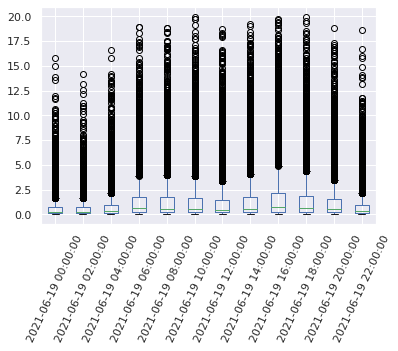

(9914, 96, 1)


In [7]:
# PATHS

pulse_dir = '../../../profiel-generatie-project/data/'
e1_1_profiles_path = f'{pulse_dir}e1_1_profiles_v2.feather'
sjv_path = f'{pulse_dir}e1_1_sjvs_v2.feather'
generated_samples_path = '../data/generated_samples/'
saved_models_path = '../data/saved_models/'

# PARAMETERS
# the training range that will be extracted from the data
start_dt, end_dt = '2021-06-19 00:00:00', '2021-06-19 23:45:00' 

profile_path = e1_1_profiles_path
sjv_path = sjv_path
cluster = 'E1_VERBRUIK_CLUSTER_1'

# scaled==True: data will be extracted in kW values x -> x * kjv * 4, 
# scaled==False: keep the data normalised
scaled = True

# load the data
e1 = ClusterData(profile_path, sjv_path, start_dt, end_dt, cluster, scaled=scaled)
# drop profiles that have a load value higher then the given parameter
e1.drop_wrong_profiles(20)
e1.plot_cluster_dist(resample_v='2H')
n_profiles = e1.df.shape[1]

# reshape the data for the TimeGAN model
X = e1.get_train_format(resample_v='15min').reshape(n_profiles, -1, 1)
# apply the log transformation as last preprocess step
ori_data = preprocess_data(X)
print(ori_data.shape)

## distribution max value per profile

(96, 9914)

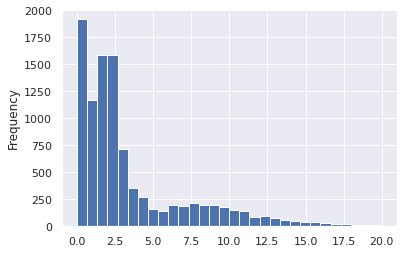

In [8]:
e1.get_max_distribution().plot(kind='hist', bins=30)
sum(e1.get_max_distribution() > 17)
e1.df.shape

## Set network parameters

TimeGAN network parameters should be optimized for different datasets.

- module: gru, lstm, or lstmLN
- hidden_dim: hidden dimensions
- num_layer: number of layers
- iteration: number of training iterations
- batch_size: the number of samples in each batch


**Note**: the used parameters below are finetuned for the scaled load profiles.
The number of iterations needed for the training run is depending on the specific task, but more than 7000 iterations seems unnecessary large.

In [13]:
## Newtork parameters

parameters = dict()

parameters['module'] = 'gru' #default: gru
parameters['hidden_dim'] = 32 #default: 24
parameters['num_layer'] = 3 #default: 3
parameters['iterations'] = 7 #default: 10000
parameters['batch_size'] = 128 #default: 128

model_name = 'test'


#paths for saving the model and generated samples 
# save_trained_model = f'{saved_models_path}{model_name}'
save_generated_samples = f'{generated_samples_path}timegan_{model_name}.csv'

#create dir to save the trained model
model_dir = f'{saved_models_path}{model_name}/'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)


Use the pretrained_path parameter to sample a saved model

If none pretrained_path is proveded, the function will train a network from scratch

# Train the timegan model

Train de timegan model met de boven opgegeven parameters. 
Als er een 'pretrained_path' mee wordt gegeven, wordt er geprobeerd om een opgeslagen getraind model te gebruiken, anders wordt er een nieuw model getraind.

In [15]:
# Run TimeGAN
n_timesteps, generated_data = timegan(np.array(ori_data), parameters)   
print('Finish Synthetic Data Generation')
np.savetxt(save_generated_samples, generated_data.reshape(n_profiles,-1), delimiter=",")


Start Embedding Network Training
step: 0/7, e_loss: 0.178
Finish Embedding Network Training
Start Training with Supervised Loss Only
step: 0/7, s_loss: 0.0874
Finish Training with Supervised Loss Only
Start Joint Training
step: 0/7, d_loss: 2.6214, g_loss_u: 0.4181, g_loss_s: 0.0375, g_loss_v: 0.0873, e_loss_t0: 0.0859
Finish Joint Training
hallo: ../data/saved_models/test/test
X name: myinput_x:0
Z name: myinput_z:0
T name: myinput_t:0
--- 5.579246759414673 seconds ---
Finish Synthetic Data Generation


# Use Trained network

In [19]:
n_timesteps, generated_data = timegan(np.array(ori_data), parameters, pretrained_path='test') 
print(generated_data.shape)

INFO:tensorflow:Restoring parameters from ../data/saved_models/test/test
(9914, 96, 1)
